<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Phyton_kriging:2D variogram </font>
</div>

- **Fecha**: 2023/06/15
        
- **Objetivos**:  Generación del variograma radial

- **Descripción** Para el variograma hace falta calcular las distancias entre los puntos 2D. Aquí se utiliza la funcion distance.cdist 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html

- **Referencias**: -

- **Autores**: 
    - Luis Miguel Sánchez Brea

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import numpy as np

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [20]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 100


In [21]:
from phyton_kriging import np, plt

from phyton_kriging.variogram_2D import theoretical
from phyton_kriging.variogram_2D import experimental
from phyton_kriging.standard_2D import kriging2D

## ejemplo sencillo

In [22]:
import scipy
from scipy.spatial import distance


In [23]:
coords = [(35.0456, -85.2672), (35.1174, -89.9711),          (35.9728, -83.9422),        (36.1667, -86.7833)]
d0 = distance.cdist(coords, coords, 'euclidean')
print(d0)

[[0.     4.7044 1.6172 1.8856]
 [4.7044 0.     6.0893 3.3561]
 [1.6172 6.0893 0.     2.8477]
 [1.8856 3.3561 2.8477 0.    ]]


# Experimental function 



In [24]:
def f_signal(x, y, width=2, sc=0, I0=0):
    """Simulation of data

    Args:
        x (np.array): x_positions
        y (np.array): y_positions
        width (flaot): width of gauss function
        sc (float or np.array): random noise
        I0 (float or np.array): detector precision

    Returns:
        y (np.array): data.
    """
    num_sensors = len(x)

    z = x + y
    z = np.sin(2 * np.pi * x / 1) * np.sin(2 * np.pi * y / 1) + x / 20
    z = np.sin(2 * np.pi * x / 0.5)
    z = 5*np.exp(-(x**2 + y**2) / (2*width**2))

    z = z + sc * np.random.randn(*z.shape)
    z = z + 2 * I0 * (np.random.rand(*z.shape) - 0.5)

    return z

In [25]:
sc = .5
I0 = .0001
width = 2

num_x = num_y = 100
num_sensors = num_x * num_y

sensors = np.zeros((num_sensors, 4), dtype=float)
positions = np.zeros((num_sensors, 2), dtype=float)



x = np.linspace(-2, 2, num_x)
y = np.linspace(-2, 2, num_y)

X, Y = np.meshgrid(x, y)
x = X.flatten()
y = Y.flatten()

x = -5 + 10 * np.random.rand(num_sensors)
y = -5 + 10 * np.random.rand(num_sensors)

sensors[:, 0] = x
sensors[:, 1] = y
sensors[:, 2] = f_signal(x, y, width, sc, I0)
sensors[:, 3] = I0 * np.ones_like(x)

#sensors[:, 2] = sensors[:, 2] + sensors[:, 3] * np.random.randn(num_sensors)

positions[:, 0] = x
positions[:, 1] = y

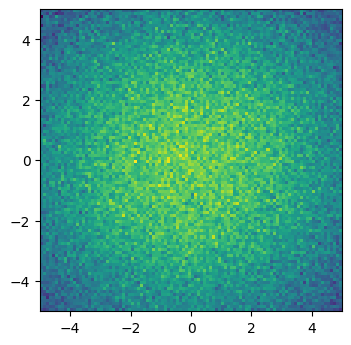

In [26]:
# X,Y = np.meshgrid(x,y)
image_Z = f_signal(X,Y, width, sc, I0)

plt.imshow(image_Z, extent=[x.min(), x.max(), y.min(), y.max()])

In [27]:
print(positions)

[[-3.6321 -0.0803]
 [-1.9839  2.4854]
 [-3.6482 -2.4042]
 ...
 [ 1.1587 -3.0606]
 [ 2.8245  2.666 ]
 [-4.3908  4.2235]]


## Con posiciones

In [2]:
from phyton_kriging.utils_math import nearest, nearest2

In [29]:
h_var = np.linspace(0,2,21)
i_var = np.arange(0,len(h_var))
variogram = np.zeros_like(i_var, dtype=float)

print(h_var)
print(i_var)


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [30]:
d0 = distance.cdist(positions, positions, 'euclidean')
print(d0)

i_distances, distances, _ = nearest2(h_var,d0)


i_distances = i_distances.astype(dtype=float)
i_distances[np.tril_indices(i_distances.shape[0], -1)] = np.nan


print(d0.shape)


d0[np.tril_indices(d0.shape[0], -1)] = np.nan

print(d0)

[[0.     3.0496 2.3239 ... 5.6422 7.0165 4.3701]
 [3.0496 0.     5.1651 ... 6.3745 4.8117 2.9688]
 [2.3239 5.1651 0.     ... 4.8515 8.2221 6.6691]
 ...
 [5.6422 6.3745 4.8515 ... 0.     5.9639 9.1572]
 [7.0165 4.8117 8.2221 ... 5.9639 0.     7.3814]
 [4.3701 2.9688 6.6691 ... 9.1572 7.3814 0.    ]]
(10000, 10000)
[[0.     3.0496 2.3239 ... 5.6422 7.0165 4.3701]
 [   nan 0.     5.1651 ... 6.3745 4.8117 2.9688]
 [   nan    nan 0.     ... 4.8515 8.2221 6.6691]
 ...
 [   nan    nan    nan ... 0.     5.9639 9.1572]
 [   nan    nan    nan ...    nan 0.     7.3814]
 [   nan    nan    nan ...    nan    nan 0.    ]]


In [31]:
print(d0.shape)

(10000, 10000)


In [32]:
for i_h in i_var:

    has_condition_distance = i_distances == i_h

    x_true, y_true = np.where(has_condition_distance)


    num_data = (has_condition_distance).sum()
    
    if num_data!=0:
        variogram_j = ((sensors[x_true,2]-sensors[y_true,2])**2).sum()/(2*num_data)
    else:
        variogram_j = None
    
    variogram[i_h]= variogram_j

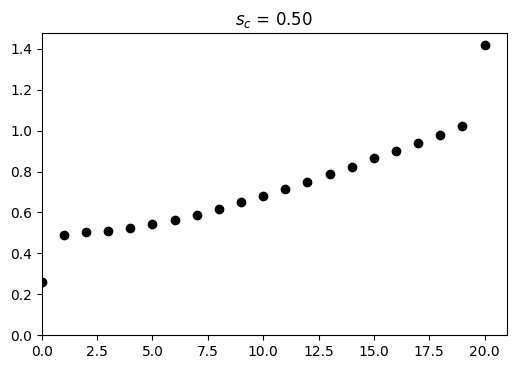

In [33]:
plt.plot(i_var, np.sqrt(variogram),'ko')
plt.xlim(0)
plt.ylim(0)
plt.title("$s_c$ = {:2.2f}".format(sc))

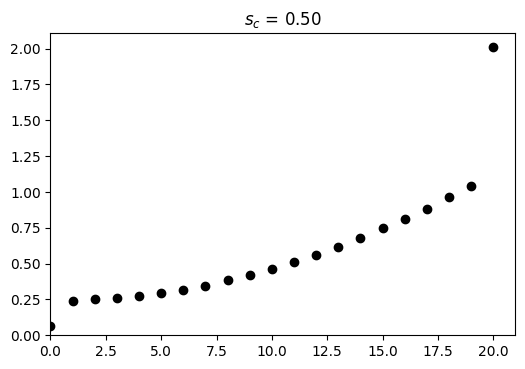

In [34]:
plt.plot(i_var, variogram,'ko')
plt.xlim(0)
plt.ylim(0)
plt.title("$s_c$ = {:2.2f}".format(sc))